In [24]:
import pandas as pd
from reload_recursive import reload_recursive
from loguru import logger
from pathlib import Path

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.agreement import mean_diff_plot
import scipy.stats as stats


import mri_data
import monai_training

In [2]:
reload_recursive(mri_data)
reload_recursive(monai_training)

from mri_data.file_manager import DataSet, scan_3Tpioneer_bids
from mri_data import file_manager as fm
from mri_data import utils
from monai_training.preprocess import DataSetProcesser

In [3]:
logger.remove()

In [4]:
drive_root = fm.get_drive_root()
msmri_home = Path("/home/srs-9/Projects/ms_mri")
training_work_dirs = msmri_home / "training_work_dirs"
dataroot = drive_root / "3Tpioneer_bids"
clinical_data_root = drive_root / "Secure_Data" / "Large"
project_dataroot = msmri_home / "data"
curr_dir = msmri_home / "analysis" / "choroid_pineal_pituitary_crosstrain_t1"

In [5]:
keep_cols = ["ms_type", "flair_contrast"]
df_full = pd.read_csv(project_dataroot / "clinical_data_full.csv", index_col="subid")
df_full = df_full[keep_cols]
df_full.index.name = "subject_id"
try:
    df_full.insert("dz_type", df_full["ms_type"])
except Exception:
    pass

df_full.loc[:, "dz_type"] = df_full["ms_type"]

df_full.loc[df_full["ms_type"] == "CIS", "dz_type"] = "RRMS"
df_full.loc[df_full["ms_type"].isin(["PPMS", "SPMS", "RPMS", "PRMS"]), "dz_type"] = (
    "PMS"
)
df_full.loc[df_full["ms_type"].isin(["NIND", "OIND", "HC"]), "dz_type"] = "!MS"

df_full.loc[:, "dz_type2"] = df_full["dz_type"]
df_full.loc[df_full["dz_type"].isin(["RRMS", "PMS"]), "dz_type2"] = "MS"

### Automatic Segmentations

In [6]:
# work_dir_names = [
#     "choroid_pineal_pituitary_T1-1",
#     "choroid_pineal_pituitary_T1-2",
#     "choroid_pineal_pituitary_T1-3",
#     "choroid_pineal_pituitary_T1-4",
# ]
# work_dirs = [training_work_dirs / name / "ensemble_output" for name in work_dir_names]
# ensemble_datasets = [
#     fm.scan_3Tpioneer_bids(work_dir, label="t1_ensemble.nii.gz")
#     for work_dir in work_dirs
# ]

### Manual Segmentations

In [7]:
# subjects = []
# for dataset in ensemble_datasets:
#     for scan in dataset:
#         subjects.append(int(scan.subid))

In [8]:
def has_subject(scan, subjects: list[int]) -> bool:
    if int(scan.subid) in subjects:
        return True
    else:
        return False

In [9]:
# orig_dataset_proc = DataSetProcesser.new_dataset(
#     dataroot, fm.scan_3Tpioneer_bids, filters=fm.filter_first_ses
# )
# orig_dataset_proc.filter([has_subject], [(subjects,)])
# orig_dataset_proc.prepare_labels(
#     ["choroid_t1_flair", "pineal", "pituitary"], ["CH", "SRS", "DT", "ED"]
# )
# orig_dataset = orig_dataset_proc.dataset

In [10]:
df = pd.read_csv(curr_dir / "dataframe.csv", index_col="subject_id")

In [11]:
df.loc[:, ["choroid_difference"]] = df["choroid_vol_auto"] - df["choroid_vol_man"]
df.loc[:, ["pineal_difference"]] = df["pineal_vol_auto"] - df["pineal_vol_man"] 
df.loc[:, ["pituitary_difference"]] = df["pituitary_vol_auto"] - df["pituitary_vol_man"]

### Automatic Segmentation Volumes

In [12]:
print("AUTO\n")

print("Choroid:")
choroid_ms_mean = df[df["dz_type"] == "RRMS"].choroid_vol_auto.mean()
choroid_ms_mean_w = df[
    (df["dz_type"] == "RRMS") & (df["flair_contrast"] == "WITH")
].choroid_vol_auto.mean()
choroid_ms_mean_wo = df[
    (df["dz_type"] == "RRMS") & (df["flair_contrast"] == "WITHOUT")
].choroid_vol_auto.mean()
choroid_notms_mean = df[df["dz_type"] == "!MS"].choroid_vol_auto.mean()
print("MS mean:             {:0.2f}".format(choroid_ms_mean))
print("MS mean w contrast:  {:0.2f}".format(choroid_ms_mean_w))
print("MS mean wo contrast: {:0.2f}".format(choroid_ms_mean_wo))
print("!MS mean:            {:0.2f}".format(choroid_notms_mean))

print("\nPineal")
pineal_ms_mean = df[df["dz_type"] == "RRMS"].pineal_vol_auto.mean()
pineal_ms_mean_w = df[
    (df["dz_type"] == "RRMS") & (df["flair_contrast"] == "WITH")
].pineal_vol_auto.mean()
pineal_ms_mean_wo = df[
    (df["dz_type"] == "RRMS") & (df["flair_contrast"] == "WITHOUT")
].pineal_vol_auto.mean()
pineal_notms_mean = df[df["dz_type"] == "!MS"].pineal_vol_auto.mean()
print("MS mean:             {:0.2f}".format(pineal_ms_mean))
print("MS mean w contrast:  {:0.2f}".format(pineal_ms_mean_w))
print("MS mean wo contrast: {:0.2f}".format(pineal_ms_mean_wo))
print("!MS mean:            {:0.2f}".format(pineal_notms_mean))

print("\nPituitary")
pituitary_ms_mean = df[df["dz_type"] == "RRMS"].pituitary_vol_auto.mean()
pituitary_ms_mean_w = df[
    (df["dz_type"] == "RRMS") & (df["flair_contrast"] == "WITH")
].pituitary_vol_auto.mean()
pituitary_ms_mean_wo = df[
    (df["dz_type"] == "RRMS") & (df["flair_contrast"] == "WITHOUT")
].pituitary_vol_auto.mean()
pituitary_notms_mean = df[df["dz_type"] == "!MS"].pituitary_vol_auto.mean()
print("MS mean:             {:0.2f}".format(pituitary_ms_mean))
print("MS mean w contrast:  {:0.2f}".format(pituitary_ms_mean_w))
print("MS mean wo contrast: {:0.2f}".format(pituitary_ms_mean_wo))
print("!MS mean:            {:0.2f}".format(pituitary_notms_mean))

AUTO

Choroid:
MS mean:             1978.13
MS mean w contrast:  1932.90
MS mean wo contrast: 2040.33
!MS mean:            1979.68

Pineal
MS mean:             228.92
MS mean w contrast:  257.86
MS mean wo contrast: 189.12
!MS mean:            218.92

Pituitary
MS mean:             710.11
MS mean w contrast:  704.73
MS mean wo contrast: 717.51
!MS mean:            733.28


### Manual Segmentation Volumes

In [13]:
print("MANUAL\n")
print("Choroid:")
choroid_ms_mean = df[df["dz_type"] == "RRMS"].choroid_vol_man.mean()
choroid_ms_mean_w = df[
    (df["dz_type"] == "RRMS") & (df["flair_contrast"] == "WITH")
].choroid_vol_man.mean()
choroid_ms_mean_wo = df[
    (df["dz_type"] == "RRMS") & (df["flair_contrast"] == "WITHOUT")
].choroid_vol_man.mean()
choroid_notms_mean = df[df["dz_type"] == "!MS"].choroid_vol_man.mean()
print("MS mean:             {:0.2f}".format(choroid_ms_mean))
print("MS mean w contrast:  {:0.2f}".format(choroid_ms_mean_w))
print("MS mean wo contrast: {:0.2f}".format(choroid_ms_mean_wo))
print("!MS mean:            {:0.2f}".format(choroid_notms_mean))

print("\nPineal")
pineal_ms_mean = df[df["dz_type"] == "RRMS"].pineal_vol_man.mean()
pineal_ms_mean_w = df[
    (df["dz_type"] == "RRMS") & (df["flair_contrast"] == "WITH")
].pineal_vol_man.mean()
pineal_ms_mean_wo = df[
    (df["dz_type"] == "RRMS") & (df["flair_contrast"] == "WITHOUT")
].pineal_vol_man.mean()
pineal_notms_mean = df[df["dz_type"] == "!MS"].pineal_vol_man.mean()
print("MS mean:             {:0.2f}".format(pineal_ms_mean))
print("MS mean w contrast:  {:0.2f}".format(pineal_ms_mean_w))
print("MS mean wo contrast: {:0.2f}".format(pineal_ms_mean_wo))
print("!MS mean:            {:0.2f}".format(pineal_notms_mean))

print("\nPituitary")
pituitary_ms_mean = df[df["dz_type"] == "RRMS"].pituitary_vol_man.mean()
pituitary_ms_mean_w = df[
    (df["dz_type"] == "RRMS") & (df["flair_contrast"] == "WITH")
].pituitary_vol_man.mean()
pituitary_ms_mean_wo = df[
    (df["dz_type"] == "RRMS") & (df["flair_contrast"] == "WITHOUT")
].pituitary_vol_man.mean()
pituitary_notms_mean = df[df["dz_type"] == "!MS"].pituitary_vol_man.mean()
print("MS mean:             {:0.2f}".format(pituitary_ms_mean))
print("MS mean w contrast:  {:0.2f}".format(pituitary_ms_mean_w))
print("MS mean wo contrast: {:0.2f}".format(pituitary_ms_mean_wo))
print("!MS mean:            {:0.2f}".format(pituitary_notms_mean))

MANUAL

Choroid:
MS mean:             1954.47
MS mean w contrast:  1956.55
MS mean wo contrast: 1951.61
!MS mean:            1880.28

Pineal
MS mean:             230.64
MS mean w contrast:  260.88
MS mean wo contrast: 189.06
!MS mean:            371.61

Pituitary
MS mean:             767.78
MS mean w contrast:  755.84
MS mean wo contrast: 784.20
!MS mean:            679.33


### Dice Scores

In [14]:
print("Choroid dice:       {:0.2f}".format(df.choroid_dice.mean()))
print("Pineal dice:        {:0.2f}".format(df.pineal_dice.mean()))
print("Pituitary dice:     {:0.2f}".format(df.pituitary_dice.mean()))

Choroid dice:       0.70
Pineal dice:        0.65
Pituitary dice:     0.82


In [15]:
print("MS choroid dice:     {:0.2f}".format(df[df.dz_type2 == "MS"].choroid_dice.mean()))
print("!MS choroid dice:    {:0.2f}".format(df[df.dz_type2 == "!MS"].choroid_dice.mean()))

print("---")
print("MS pineal dice:      {:0.2f}".format(df[df.dz_type2 == "MS"].pineal_dice.mean()))
print("!MS pineal dice:     {:0.2f}".format(df[df.dz_type2 == "!MS"].pineal_dice.mean()))

print("---")
print("MS pituitary dice:   {:0.2f}".format(df[df.dz_type2 == "MS"].pituitary_dice.mean()))
print("!MS pituitary dice:  {:0.2f}".format(df[df.dz_type2 == "!MS"].pituitary_dice.mean()))

MS choroid dice:     0.69
!MS choroid dice:    0.70
---
MS pineal dice:      0.70
!MS pineal dice:     0.61
---
MS pituitary dice:   0.81
!MS pituitary dice:  0.83


Look at volume differences between auto and man for MS and !MS

In [16]:
print(
    "MS choroid difference:    {:0.2f}".format(
        df[df.dz_type2 == "MS"].choroid_difference.mean()
    )
)
print(
    "!MS choroid difference:   {:0.2f}".format(
        df[df.dz_type2 == "!MS"].choroid_difference.mean()
    )
)

print("\n")
print(
    "MS pineal difference:     {:0.2f}".format(
        df[df.dz_type2 == "MS"].pineal_difference.mean()
    )
)
print(
    "!MS pineal difference:    {:0.2f}".format(
        df[df.dz_type2 == "!MS"].pineal_difference.mean()
    )
)

print("\n")
print(
    "MS pituitary difference:   {:0.2f}".format(
        df[df.dz_type2 == "MS"].pituitary_difference.mean()
    )
)
print(
    "!MS pituitary difference:  {:0.2f}".format(
        df[df.dz_type2 == "!MS"].pituitary_difference.mean()
    )
)

MS choroid difference:    23.66
!MS choroid difference:   99.40


MS pineal difference:     -1.73
!MS pineal difference:    -152.70


MS pituitary difference:   -57.67
!MS pituitary difference:  53.95


### Histograms

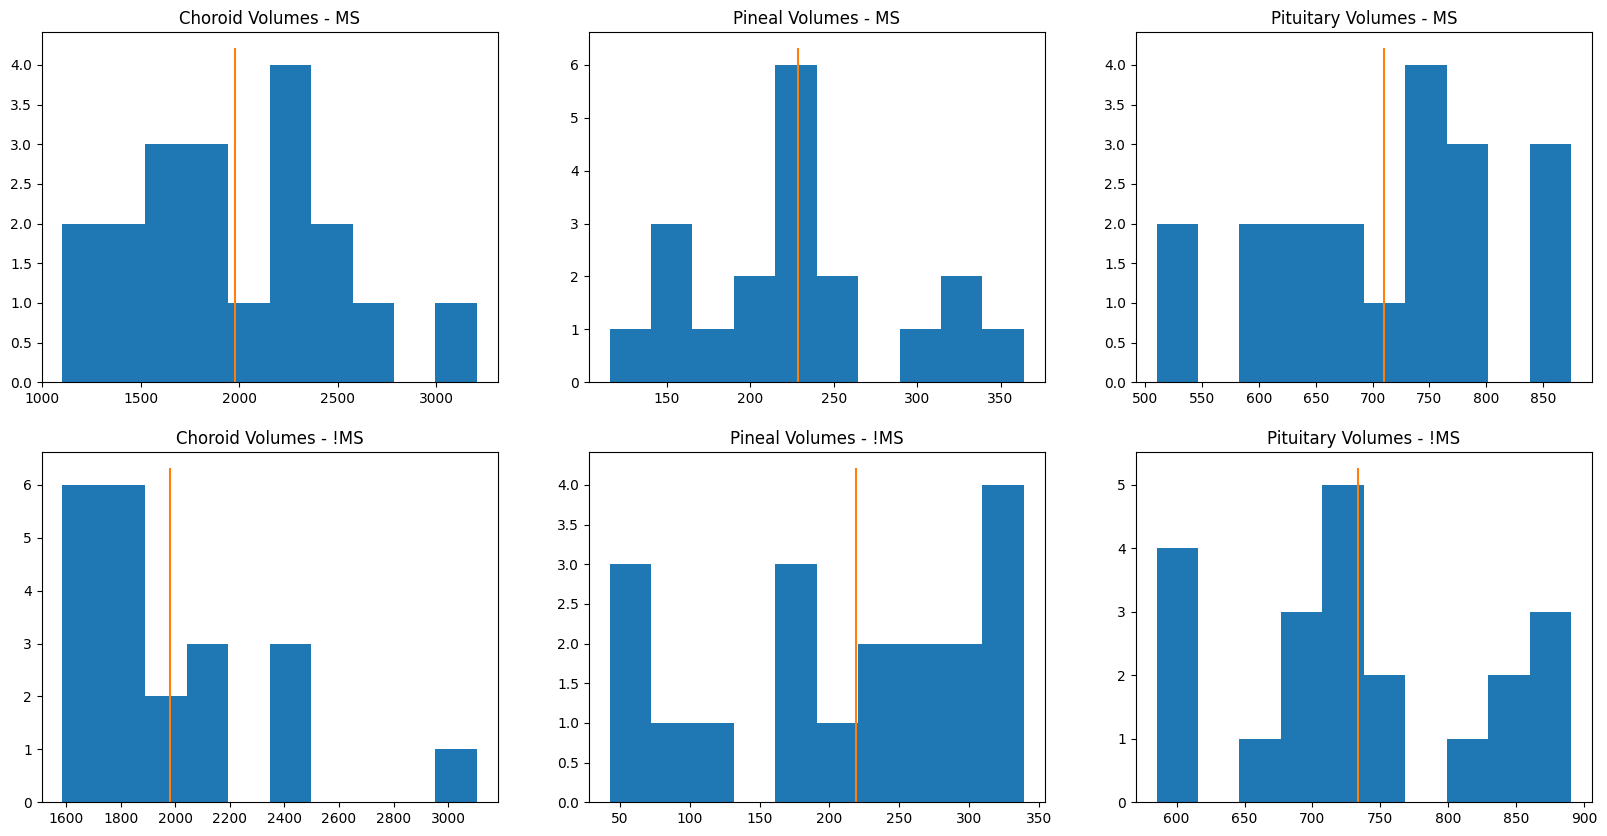

In [17]:
fig, axes = plt.subplots(2, 3)
fig.set_figwidth(20)
fig.set_figheight(10)

ax = axes[0,0]
ax.hist(df.loc[df["dz_type2"] == "MS", "choroid_vol_auto"])
ax.set_title("Choroid Volumes - MS")
mean_vol = df.loc[df["dz_type2"] == "MS", "choroid_vol_auto"].mean()
ax.plot([mean_vol, mean_vol], ax.get_ylim())


ax = axes[0,1]
ax.hist(df.loc[df["dz_type2"] == "MS", "pineal_vol_auto"])
ax.set_title("Pineal Volumes - MS")
mean_vol = df.loc[df["dz_type2"] == "MS", "pineal_vol_auto"].mean()
ax.plot([mean_vol, mean_vol], ax.get_ylim())


ax = axes[0,2]
ax.hist(df.loc[df["dz_type2"] == "MS", "pituitary_vol_auto"])
ax.set_title("Pituitary Volumes - MS")
mean_vol = df.loc[df["dz_type2"] == "MS", "pituitary_vol_auto"].mean()
ax.plot([mean_vol, mean_vol], ax.get_ylim())


ax = axes[1,0]
ax.hist(df.loc[df["dz_type2"] == "!MS", "choroid_vol_auto"])
ax.set_title("Choroid Volumes - !MS")
mean_vol = df.loc[df["dz_type2"] == "!MS", "choroid_vol_auto"].mean()
ax.plot([mean_vol, mean_vol], ax.get_ylim())


ax = axes[1,1]
#manually remove outlier
ax.hist(df.loc[(df["dz_type2"] == "!MS") & (df['pineal_difference'] > -400), "pineal_vol_auto"])
ax.set_title("Pineal Volumes - !MS")
mean_vol = df.loc[df["dz_type2"] == "!MS", "pineal_vol_auto"].mean()
ax.plot([mean_vol, mean_vol], ax.get_ylim())


ax = axes[1,2]
ax.hist(df.loc[df["dz_type2"] == "!MS", "pituitary_vol_auto"])
ax.set_title("Pituitary Volumes - !MS")
mean_vol = df.loc[df["dz_type2"] == "!MS", "pituitary_vol_auto"].mean()
ax.plot([mean_vol, mean_vol], ax.get_ylim())

Text(153.84487025000004, 7.202999999999999, 'Dice=0.83')

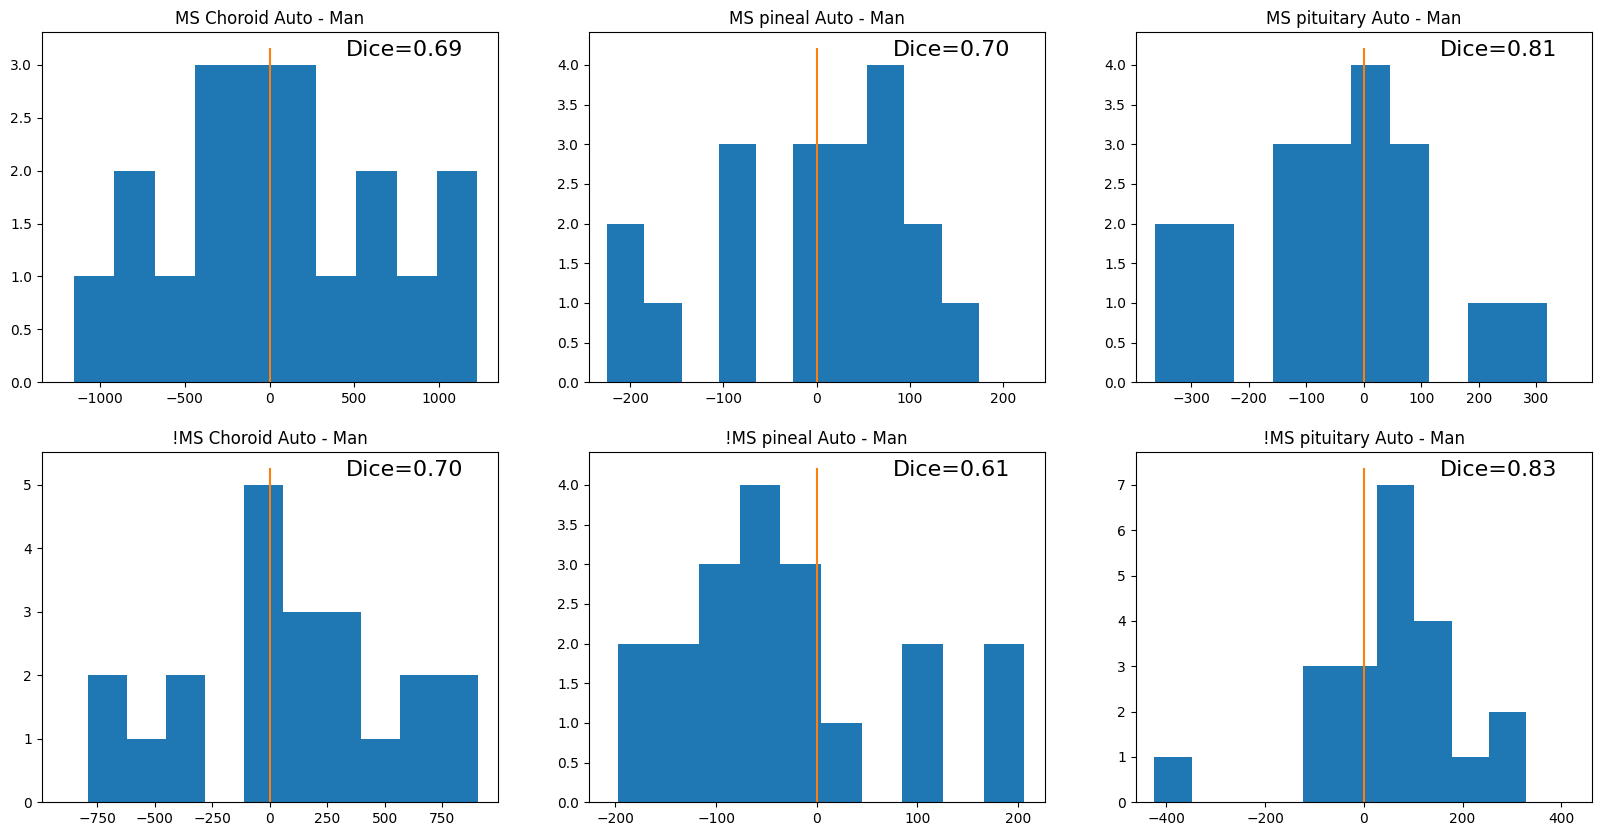

In [18]:
fig, axes = plt.subplots(2, 3)
fig.set_figwidth(20)
fig.set_figheight(10)

ax = axes[0,0]
ax.hist(df.loc[df["dz_type2"] == "MS", "choroid_difference"])
ax.set_title("MS Choroid Auto - Man")
ax.plot([0, 0], ax.get_ylim())
x_extent = max([abs(ext) for ext in ax.get_xlim()])
ax.set_xlim([-x_extent, x_extent])
text_y = ax.get_ylim()[1] - ax.get_ylim()[1] / 15
text_x = x_extent-(x_extent/1.5)
ax.text(text_x, text_y, "Dice={:0.2f}".format(df[df.dz_type2 == "MS"].choroid_dice.mean()), size=16)


ax = axes[0,1]
ax.hist(df.loc[df["dz_type2"] == "MS", "pineal_difference"])
ax.set_title("MS pineal Auto - Man")
ax.plot([0, 0], ax.get_ylim())
x_extent = max([abs(ext) for ext in ax.get_xlim()])
ax.set_xlim([-x_extent, x_extent])
text_y = ax.get_ylim()[1] - ax.get_ylim()[1] / 15
text_x = x_extent-(x_extent/1.5)
ax.text(text_x, text_y, "Dice={:0.2f}".format(df[df.dz_type2 == "MS"].pineal_dice.mean()), size=16)


ax = axes[0,2]
ax.hist(df.loc[df["dz_type2"] == "MS", "pituitary_difference"])
ax.set_title("MS pituitary Auto - Man")
ax.plot([0, 0], ax.get_ylim())
x_extent = max([abs(ext) for ext in ax.get_xlim()])
ax.set_xlim([-x_extent, x_extent])
text_y = ax.get_ylim()[1] - ax.get_ylim()[1] / 15
text_x = x_extent-(x_extent/1.5)
ax.text(text_x, text_y, "Dice={:0.2f}".format(df[df.dz_type2 == "MS"].pituitary_dice.mean()), size=16)


ax = axes[1,0]
ax.hist(df.loc[df["dz_type2"] == "!MS", "choroid_difference"])
ax.set_title("!MS Choroid Auto - Man")
ax.plot([0, 0], ax.get_ylim())
x_extent = max([abs(ext) for ext in ax.get_xlim()])
ax.set_xlim([-x_extent, x_extent])
text_y = ax.get_ylim()[1] - ax.get_ylim()[1] / 15
text_x = x_extent-(x_extent/1.5)
ax.text(text_x, text_y, "Dice={:0.2f}".format(df[df.dz_type2 == "!MS"].choroid_dice.mean()), size=16)


ax = axes[1,1]
#manually remove outlier
ax.hist(df.loc[(df["dz_type2"] == "!MS") & (df['pineal_difference'] > -400), "pineal_difference"])
ax.set_title("!MS pineal Auto - Man")
ax.plot([0, 0], ax.get_ylim())
x_extent = max([abs(ext) for ext in ax.get_xlim()])
ax.set_xlim([-x_extent, x_extent])
text_y = ax.get_ylim()[1] - ax.get_ylim()[1] / 15
text_x = x_extent-(x_extent/1.5)
ax.text(text_x, text_y, "Dice={:0.2f}".format(df[df.dz_type2 == "!MS"].pineal_dice.mean()), size=16)


ax = axes[1,2]
ax.hist(df.loc[df["dz_type2"] == "!MS", "pituitary_difference"])
ax.set_title("!MS pituitary Auto - Man")
ax.plot([0, 0], ax.get_ylim())
x_extent = max([abs(ext) for ext in ax.get_xlim()])
ax.set_xlim([-x_extent, x_extent])
text_y = ax.get_ylim()[1] - ax.get_ylim()[1] / 15
text_x = x_extent-(x_extent/1.5)
ax.text(text_x, text_y, "Dice={:0.2f}".format(df[df.dz_type2 == "!MS"].pituitary_dice.mean()), size=16)

## Stats

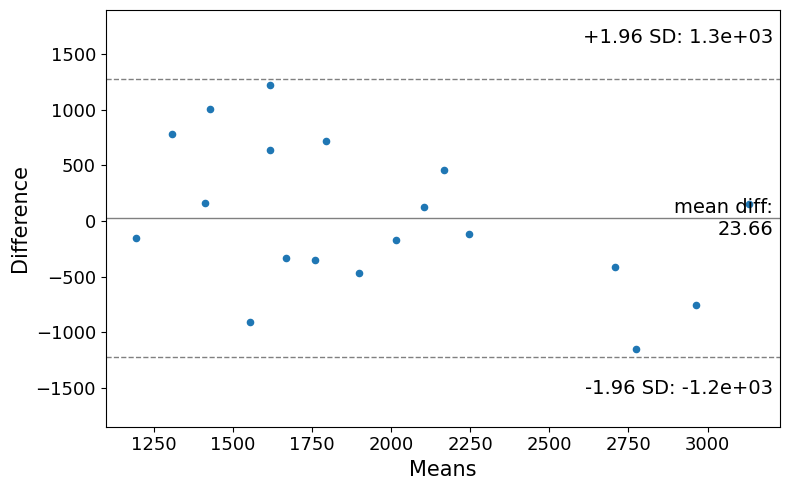

In [19]:
data = df.loc[df["dz_type2"] == "MS", ['choroid_vol_man', 'choroid_vol_auto']].dropna()

f, ax = plt.subplots(1, figsize = (8,5))
mean_diff_plot(data['choroid_vol_auto'], data['choroid_vol_man'], ax=ax)
plt.show()

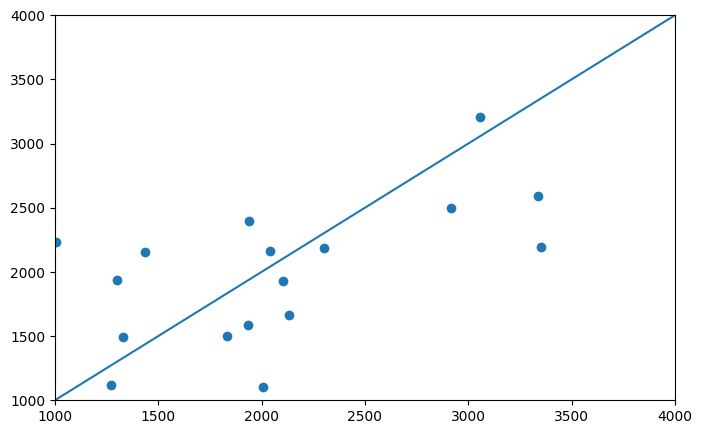

Pearson correlation coefficient: 0.5486393570994879
p-value: 0.01499652266343541


In [27]:
data = df.loc[df["dz_type2"] == "MS", ['choroid_vol_man', 'choroid_vol_auto']].dropna()
f, ax = plt.subplots(1, figsize = (8,5))
plt.scatter(data['choroid_vol_man'], data['choroid_vol_auto'])
ax.set_xlim([1000,4000])
ax.set_ylim([1000, 4000])
plt.plot([1000, 4000], [1000, 4000])
plt.show()

corr_coef, p_value = stats.pearsonr(data['choroid_vol_man'], data['choroid_vol_auto'])
print("Pearson correlation coefficient:", corr_coef)
print("p-value:", p_value)

### Regressions

OLS

In [42]:
# MS = 0; !MS = 1
outcome = "pituitary_vol_man"

df_test = df[df['dz_type2'].isin(['MS', '!MS'])]

df_test.loc[:, 'sex_factor'], _ = df_test['sex'].factorize()
df_test.loc[:, 'dz_type2_factor'], _ = df_test['dz_type2'].factorize(sort=False)

predictors = ["age", "sex_factor", "tiv", "dz_type2_factor"]

x = np.asarray(df_test[predictors]).astype(np.float64)
Y = np.asarray(df_test[outcome]).astype(np.float64)

mod = sm.OLS(Y, x, missing='drop')

res = mod.fit()

print(predictors, "\n")
print(res.summary())

['age', 'sex_factor', 'tiv', 'dz_type2_factor'] 

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.953
Model:                            OLS   Adj. R-squared (uncentered):              0.947
Method:                 Least Squares   F-statistic:                              162.5
Date:                Thu, 16 Jan 2025   Prob (F-statistic):                    8.96e-21
Time:                        17:50:24   Log-Likelihood:                         -234.58
No. Observations:                  36   AIC:                                      477.2
Df Residuals:                      32   BIC:                                      483.5
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025    

In [149]:
volume = 'choroid_vol_auto'
data = df[['dz_type2', 'age', 'sex', 'tiv', 'flair_contrast', volume]]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type2'].isin(['MS', '!MS'])]
data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type2']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)

predictors = ["age", "Female", "tiv", 'WITH', "MS"]

y = data['volume']
x = data[predictors]
print(x.columns.tolist(), "\n")

x = np.asarray(x, dtype='float64')
res = sm.OLS(y, x, missing='drop').fit()
print(res.summary())


['age', 'Female', 'tiv', 'WITH', 'MS'] 

                                 OLS Regression Results                                
Dep. Variable:                 volume   R-squared (uncentered):                   0.969
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                              180.2
Date:                Tue, 14 Jan 2025   Prob (F-statistic):                    6.55e-21
Time:                        15:12:54   Log-Likelihood:                         -246.17
No. Observations:                  34   AIC:                                      502.3
Df Residuals:                      29   BIC:                                      510.0
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]


Logistic

In [37]:
df_test['dz_type2_factor']

subject_id
1010    0
1011    0
1019    0
1029    1
1033    0
1037    0
1038    0
1080    0
1085    0
1087    0
1089    0
1109    0
1119    0
1152    0
1163    1
1188    0
1191    1
1234    0
1259    0
1265    0
1272    0
1280    1
1293    0
1321    1
1355    1
1437    1
1498    1
1518    1
1540    1
1547    1
1548    1
2081    1
2083    1
2097    1
2126    1
2132    1
2144    1
2146    1
2164    1
2187    1
Name: dz_type2_factor, dtype: int64

### Inspect Segmentations

In [115]:
df.index.name = "subject_id"
df = df.sort_values(by=["dz_type2", "subject_id"])

In [116]:
df = df.sort_values(by=["choroid_difference"])

In [118]:
for i, row in df.iterrows():
    images = [
        Path(row["scan_folder"]) / "flair.nii.gz",
        Path(row["scan_folder"]) / "t1.nii.gz",
    ]
    labels = [row["auto_label"], row["manual_label"]]
    cmd = utils.open_itksnap_workspace_cmd(images, labels)
    df.loc[i, "itksnap_cmd"] = cmd

In [136]:
import pyperclip
import subprocess

pyperclip.copy(df.loc[1010, "itksnap_cmd"])
subprocess.Popen(df.loc[1010, "itksnap_cmd"].split(" "))


<Popen: returncode: None args: ['itksnap', '-g', '/media/smbshare/3Tpioneer_...>

Launching ITK-SNAP


In [86]:
print(df.loc[1010, "itksnap_cmd"])

itksnap -g H:/3Tpioneer_bids/sub-ms1010/ses-20180208/flair.nii.gz -o H:/3Tpioneer_bids/sub-ms1010/ses-20180208/t1.nii.gz -s H:/training_work_dirs/choroid_pineal_pituitary3/ensemble_output/sub-ms1010/ses-20180208/flair.t1_ensemble.nii.gz H:/3Tpioneer_bids/sub-ms1010/ses-20180208/choroid_t1_flair-CH.pineal-CH.pituitary-CH.nii.gz


In [25]:
lines = ["# Notes", "\n\n"]
dz_type = ""
for i, row in df.iterrows():
    if row["dz_type2"] != dz_type:
        lines.extend([f"## {row['dz_type2']}", "\n\n"])
        dz_type = row["dz_type2"]
    lines.extend([f"### {i}", "\n\n"])

In [26]:
import os

if not os.path.exists("seg_notes.md"):
    with open("seg_notes.md", "w") as f:
        f.writelines(lines)